In [1]:
import toml
import psycopg2
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_theme()

In [2]:
config = toml.load("./db.toml")['psql']
conn = psycopg2.connect(
    host=config['host'],
    port=config['port'],
    database=config['database'],
    user=config['user'],
    password=config['password'],
)

In [7]:
cur = conn.cursor()
cur.execute(
    f"""
    WITH cte AS (--
        SELECT s.*,
               EXTRACT('epoch' FROM least(upper(s.uptime),'2023-01-30') - greatest('2023-01-23'::TIMESTAMPTZ, lower(s.uptime))) session_length_s
        FROM sessions s
        WHERE s.uptime && tstzrange('2023-01-23', '2023-01-30')
    )
    SELECT
        cte.peer_id,
        percentile_cont(0.5) WITHIN GROUP(ORDER BY cte.session_length_s) median_session_length,
        avg(cte.session_length_s) average_session_length,
        sum(cte.session_length_s) total_uptime,
        count(cte.id) session_count
    FROM cte
    GROUP BY cte.peer_id
    ORDER BY 2 DESC
    """
)
data = cur.fetchall()

In [8]:
df = pd.DataFrame(data, columns=["peer_id", "median_session_length_s", "average_session_length_s", "uptime_s", "sessions"])
df["uptime_d"] = df["uptime_s"] / 86_400
df["median_session_length_d"] = df["median_session_length_s"] / 86_400
df["average_session_length_d"] = df["average_session_length_s"] / 86_400
df

,peer_id,median_session_length_s,average_session_length_s,uptime_s,sessions,uptime_d,median_session_length_d,average_session_length_d
0,281641,604800.000000,604800.000000,604800.000000,1,7.000000e+00,7.000000e+00,7.000000e+00
1,3,604800.000000,604800.000000,604800.000000,1,7.000000e+00,7.000000e+00,7.000000e+00
2,5,604800.000000,604800.000000,604800.000000,1,7.000000e+00,7.000000e+00,7.000000e+00
3,7,604800.000000,604800.000000,604800.000000,1,7.000000e+00,7.000000e+00,7.000000e+00
4,154621,604800.000000,604800.000000,604800.000000,1,7.000000e+00,7.000000e+00,7.000000e+00
...,...,...,...,...,...,...,...,...
68873,246833,0.021508,30.344340,637.231139,21,7.375360e-03,2.489352e-07,3.512076e-04
68874,346431,0.015414,69.478420,3057.050494,44,3.538253e-02,1.784086e-07,8.041484e-04
68875,324769,0.014862,0.733096,2.199287,3,2.545471e-05,1.720139e-07,8.484904e-06
68876,17810,0.008100,0.008100,0.008100,1,9.375000e-08,9.375000e-08,9.375000e-08


Text(0, 0.5, 'Average Session Length in Days')

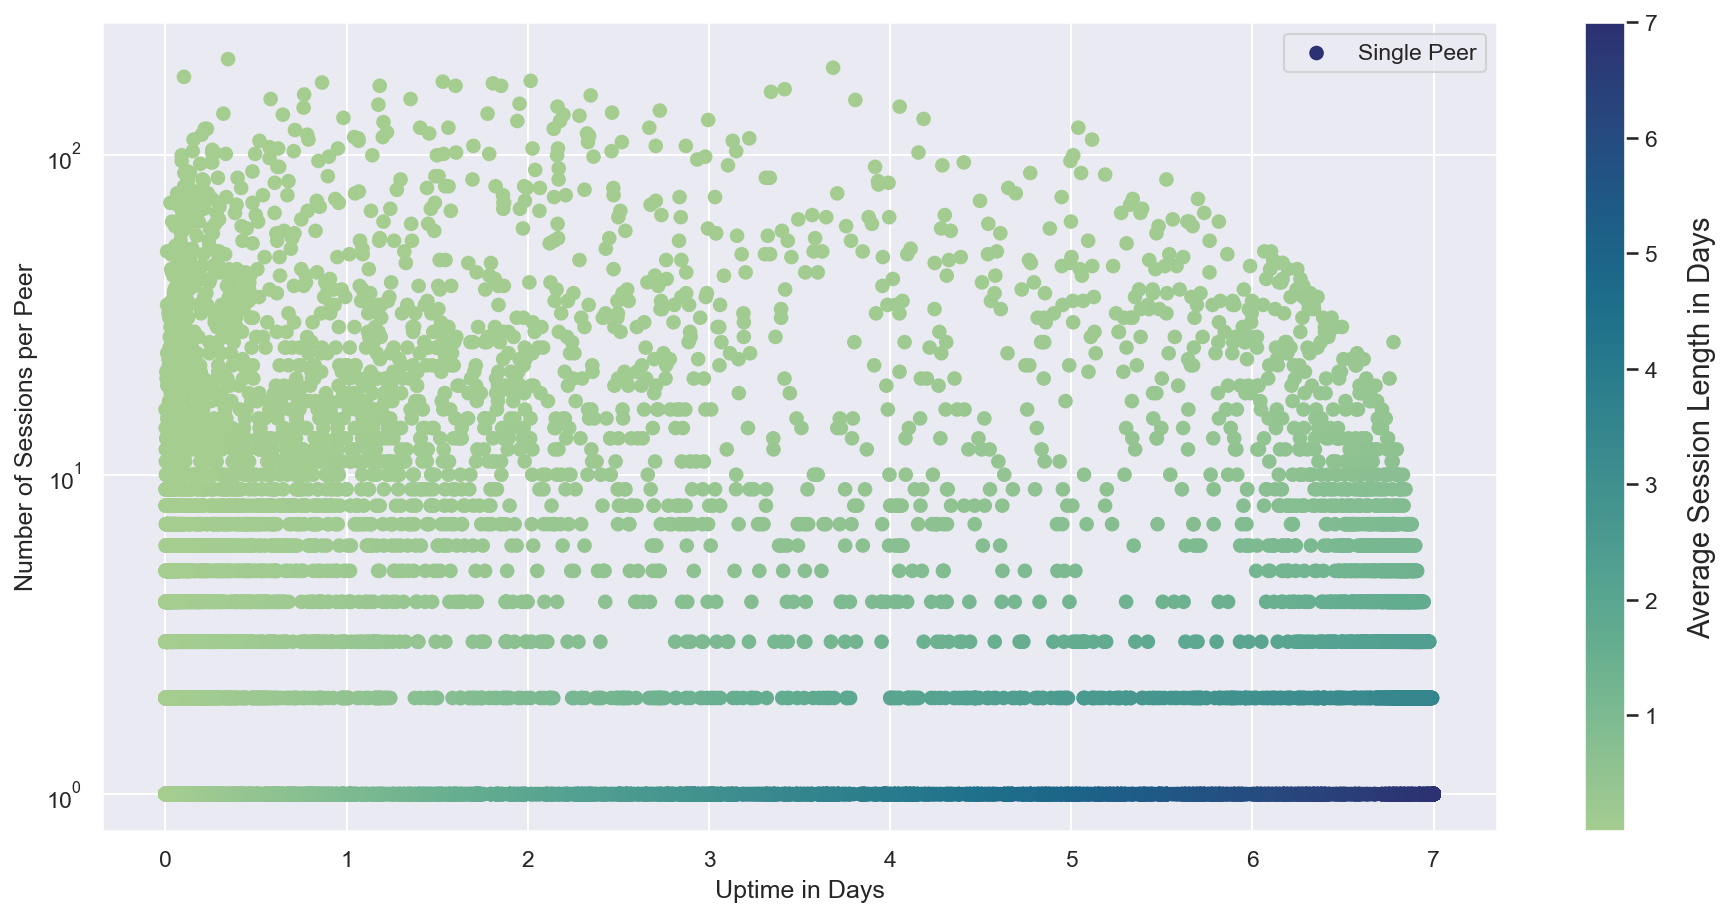

In [9]:
fig, ax = plt.subplots(figsize=[15, 7], dpi=150)

cmap = sns.color_palette("crest", as_cmap=True)
norm = mpl.colors.Normalize()
sc = ax.scatter(df["uptime_d"], df["sessions"], c=df["average_session_length_d"], label="Single Peer", cmap=cmap, norm=norm)

ax.set_xlabel("Uptime in Days")
ax.set_ylabel("Number of Sessions per Peer")
ax.legend()
cbar = fig.colorbar(sc, ax=ax)

ax.set_yscale("log")

# ax.grid(True, which="both")

cbar.ax.set_ylabel("Average Session Length in Days", labelpad=15, fontdict={"size": 14})

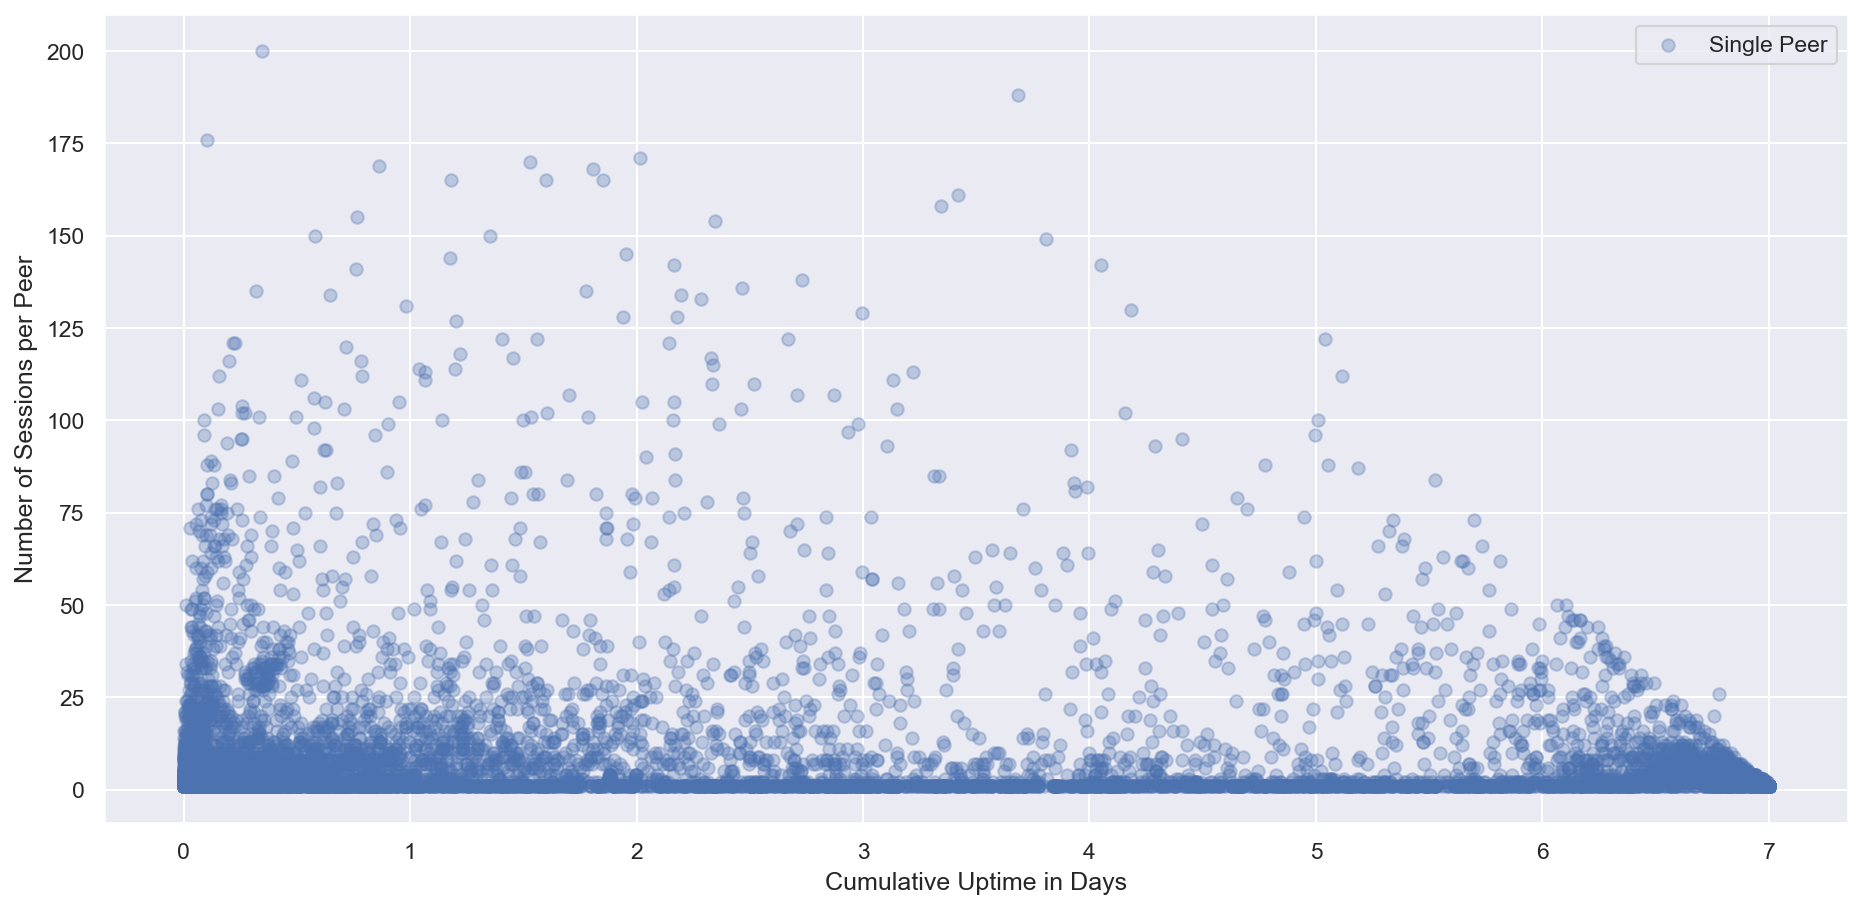

In [10]:
fig, ax = plt.subplots(figsize=[15, 7], dpi=150)

ax.scatter(df["uptime_d"], df["sessions"], label="Single Peer", alpha=0.3)

ax.set_xlabel("Cumulative Uptime in Days")
ax.set_ylabel("Number of Sessions per Peer")
ax.legend()
